In [ ]:
# default_exp data

# DICOM preprocessing methods

> ...

In [1]:
from nbdev import *

In [2]:
# export

import os
import random
from scipy.ndimage import zoom
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
# export

from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage import filters
from scipy import ndimage

from lunglens.data import read_dicom_folder, read_dicom_file, print_slice, print_hist, appply_window
#from skimage.transform import resize
from scipy.interpolate import interp2d


#### know chalanging cases

In [4]:
cases = []
cases.append(['../data/extracted/osic-pulmonary-fibrosis-progression/ID00078637202199415319443', 87])
cases.append(['../data/extracted/osic-pulmonary-fibrosis-progression/ID00398637202303897337979', 40])
cases.append(['..\data\extracted\osic-pulmonary-fibrosis-progression\ID00232637202260377586117', 44])
cases.append(['..\data\extracted\osic-pulmonary-fibrosis-progression\ID00128637202219474716089', 11])

case_sel = 3
(case_scan, case_slice) = cases[case_sel]

### the scan preperation flow

In [5]:
# export

def prepare_scan(scan_folder, slice_size=512, window=[-600, 900], show_stages=False, slice_idx=None):
    
    # read the scan
    if slice==None:
        data, itk_image = read_dicom_folder(scan_folder)
    else:
        if str.find(scan_folder, 'extracted') > 0:
            slice_file = scan_folder + '\\' + str(slice_idx) + '.dcm'
            data, itk_image = read_dicom_file(slice_file)
        else:
            slice_file = scan_folder + '\\' + str(slice_idx) + '.npy'
            data = np.load(slice_file)
            data = data.reshape(1, data.shape[0], data.shape[1])
    nrows, ncols = data.shape[1:3]
    ytags = np.linspace(0, nrows, slice_size)
    xtags = np.linspace(0, ncols, slice_size)

    # resize all images in the scan
    scan_resized = np.zeros((data.shape[0], slice_size, slice_size))
    for i in range(data.shape[0]):
        f = interp2d(np.arange(nrows), np.arange(ncols), data[i])
        scan_resized[i] = f(ytags, xtags)
    
    # radiological window and normalize
    scan = appply_window(scan_resized, l=window[0], w=window[1]-window[0], normalize=True)
    
    # show random slice
    if show_stages:
        fig, ax = plt.subplots(2, 2, figsize=[10, 10])
        slice_idx = np.random.randint(scan.shape[0])
        ax[0, 0].set_title('not windowed')
        ax[0, 1].set_title('windowed')
        ax[1, 0].set_title('slice ' + str(slice_idx))
        ax[1, 1].set_title('slice ' + str(slice_idx))
        ax[0, 0].hist(scan_resized[0].flatten(), bins=100)
        ax[0, 1].hist(scan[0].flatten(), bins=100)
        ax[1, 0].imshow(scan_resized[slice_idx], cmap='gray')
        ax[1, 1].imshow(scan[slice_idx], cmap='gray')
        plt.show()
    
    return scan

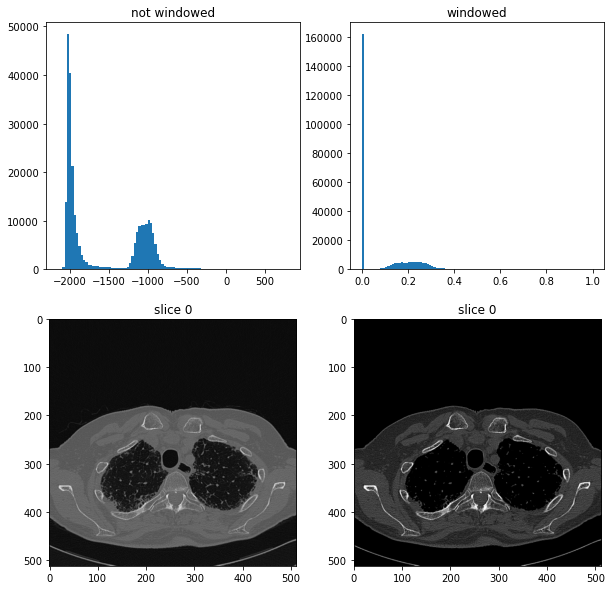

(1, 512, 512)


In [6]:
ds_dir = Path('../data/extracted/osic-pulmonary-fibrosis-progression')
all_files = list(ds_dir.rglob('ID0*'))
#random_scan = random.choice(all_files)
random_scan = case_scan
random_slice = case_slice

scan = prepare_scan(random_scan, show_stages=True, slice_idx=random_slice)
print(scan.shape)
slice_idx = 0 # we only return single slice

### define segmentation tools

In [77]:
# export

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max_gray = np.max(img)
    min_gray = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    if False:
        img[img==max_gray]=mean
        img[img==min_gray]=mean
    else:
        mask_0 = (img < max_gray) * (img > min_gray)
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    #kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    if display:
        print(np.atleast_2d(img[mask_0].flatten()).shape, np.reshape(middle,[np.prod(middle.shape),1]).shape)
    kmeans = KMeans(n_clusters=2).fit(np.atleast_2d(img[mask_0].flatten()).T)
    centers = sorted(kmeans.cluster_centers_.flatten())
    if display:
        print('kmeans centers:', centers)
    threshold = np.mean(centers[:2])
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    #
    # do the detection over blured image
    #blured_img = filters.gaussian(img, sigma=5, preserve_range=True)
    blured_img = ndimage.minimum_filter(img, size=10)
    blured_img = filters.gaussian(blured_img, sigma=5, preserve_range=True)
    kmeans = KMeans(n_clusters=2).fit(np.atleast_2d(blured_img[mask_0].flatten()).T)
    centers = sorted(kmeans.cluster_centers_.flatten())
    if display:
        print('kmeans centers (blured img):', centers)
    threshold = np.mean(centers[:2])
    blured_thresh_img = np.where(0.98*blured_img<threshold,1.0,0.0)  # threshold the image
    blured_thresh_img = morphology.binary_erosion(blured_thresh_img, np.ones([10,10]))
    thresh_img += blured_thresh_img
    #gray_hist = np.histogram(blured_img[mask].flatten(), bins=500)
   # plt.plot((gray_hist[1][:-1]+gray_hist[1][1:])/2, gray_hist[0])

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.binary_erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.binary_dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    #print('label_vals:', label_vals)
    #print(len(regions))
    good_labels = []
    for prop in regions:
        B = prop.bbox
        #print(prop.label, ':', B)
        #if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
        # modify rules, menashe, oct.3
        span_ok =  B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9
        margin_ok = B[0]>row_size/10 and B[2]<col_size/10*9
        if span_ok and margin_ok:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    if display:
        print('good_labels:', good_labels)
    if len(good_labels) > 4:
        # take up to 4 dominant regions (menashe, oct.3)
        label_weight = [np.where(labels==N,1,0).sum() for N in good_labels]
        #good_labels = [good_labels[i] for i in np.argsort(label_weight)[-4:]]
        label_ordering = np.flip(np.argsort(label_weight))
        cum_weight = np.cumsum(np.array(label_weight)[label_ordering])
        num_admit = int(max(4, np.argwhere(cum_weight < (1/10) * img.size)[-1]))
        good_labels = [good_labels[label_ordering[i]] for i in range(num_admit)]
        if display:
            print('selected', num_admit, 'labels:', good_labels)
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    #mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(2, 2, figsize=[8, 8])
        ax[0, 0].set_title("Histograms (all img)")
        gray_hist = np.histogram(img[mask_0].flatten(), bins=500)
        ax[0, 0].plot((gray_hist[1][:-1]+gray_hist[1][1:])/2, gray_hist[0])
        gray_hist = np.histogram(blured_img[mask_0].flatten(), bins=500)
        ax[0, 0].plot((gray_hist[1][:-1]+gray_hist[1][1:])/2, gray_hist[0])
        ax[0, 1].set_title("Histograms (middle)")
        ax[1, 0].imshow(blured_img, cmap='gray')
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask #mask*img


segment slice 0
(1, 100171) (94249, 1)
[0.21134025726428576, 0.5767540506605068]
[0.05139377477399012, 0.11312676523596102]
good_labels: []


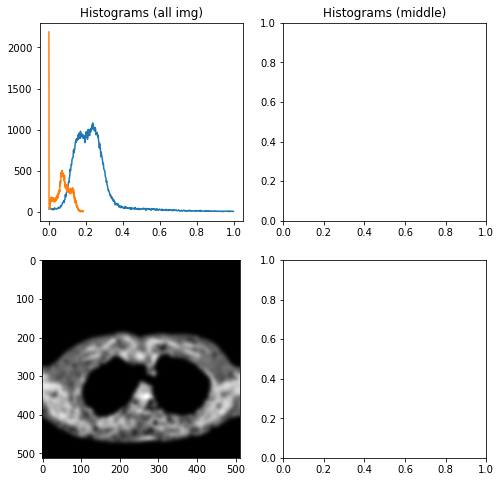

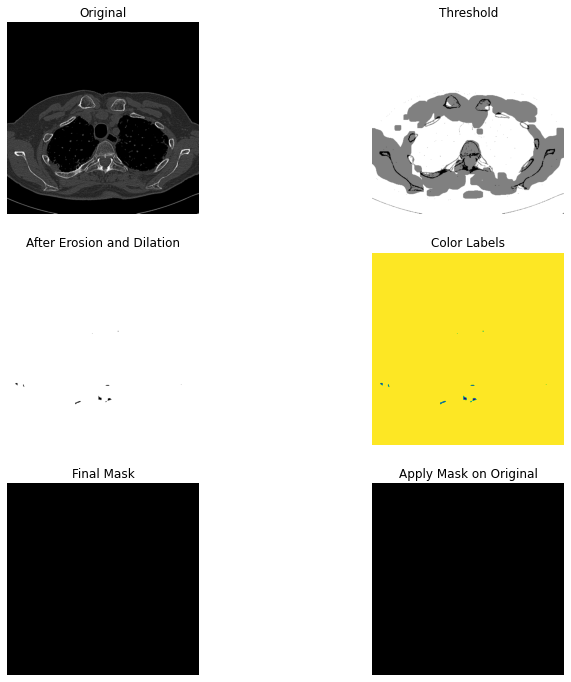

In [8]:
#slice_idx = np.random.randint(scan.shape[0])
#slice_idx = case_slice
print('segment slice', slice_idx)
mask = make_lungmask(scan[slice_idx], display=True)
#print_slice(mask)

### get patches from mask

In [48]:
# export

def get_patches(img, mask, patch_size=64, min_occupancy=0.125, show_tiling=False):
    
    tile_num_pixels = patch_size * patch_size
    thd_pop = tile_num_pixels * min_occupancy
    
    # create grid of partialy overlapping tiles
    sets = 1 
    tile_left_coor = np.arange(0, mask.shape[0]-patch_size+1, int(patch_size / sets), dtype=int)
    tile_upper_coor = np.arange(0, mask.shape[1]-patch_size+1, int(patch_size / sets), dtype=int)
    # tile_left_coor = tile_left_coor.reshape([-1, sets]).T
    # tile_upper_coor = tile_upper_coor.reshape([-1, sets]).T
    print(tile_left_coor, '\n', tile_upper_coor, '\n\n TBD VALIDITY CHECK\n\n')
    
    # select sub-grid with best coverage
    patches, positions = [], []
    if show_tiling:
        tile_map = np.zeros(mask.shape)
        tile_img = np.copy(img) * (1 + mask)
    for i_left in tile_left_coor:
        for i_upper in tile_upper_coor:
            tile_mask = mask[i_upper:i_upper+patch_size, i_left:i_left+patch_size]
            if tile_mask.sum() > thd_pop:
                patches.append(img[i_upper:i_upper+patch_size, i_left:i_left+patch_size] * tile_mask)
                positions.append([i_upper, i_left])
                if show_tiling:
                    tile_map[i_upper:i_upper+patch_size, i_left:i_left+patch_size] = 0.5
                    tile_img[i_upper:i_upper+patch_size, i_left:i_left+patch_size] *= 2
    
    # visualize tiling
    if show_tiling:
        tile_map += mask
        for i_left in tile_left_coor:
            tile_map[:, i_left] = 2
            tile_img[:, i_left] = 2
            for i_upper in tile_upper_coor:
                tile_map[i_upper, :] = 2
                tile_img[i_upper, :] = 2
        #print_slice(tile_map)
        print_slice(tile_img)

    
    # take the grids that include enough pixels
    
    return patches, positions
    

(512, 512)
[  0  32  64  96 128 160 192 224 256 288 320 352 384 416 448 480] 
 [  0  32  64  96 128 160 192 224 256 288 320 352 384 416 448 480] 

 TBD VALIDITY CHECK




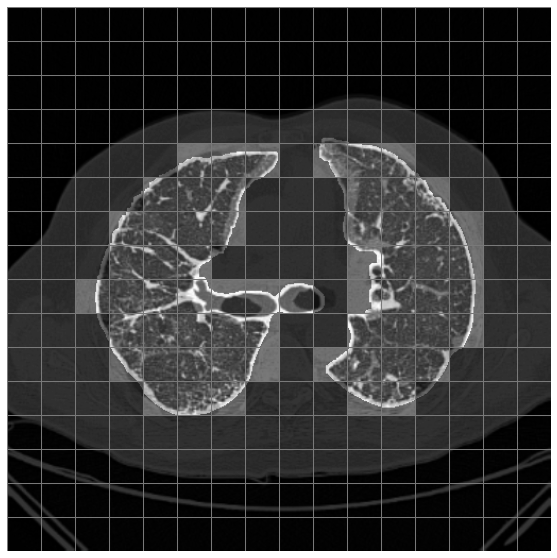

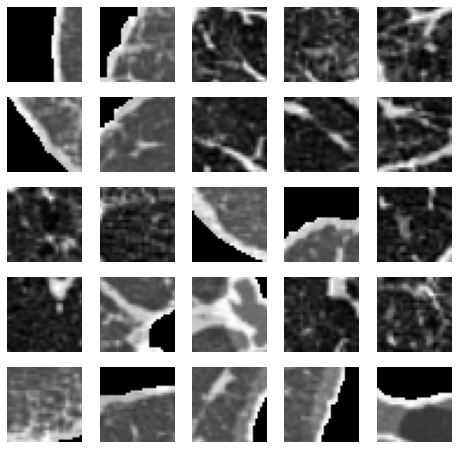

In [49]:
print(scan[slice_idx].shape)
patches, positions = get_patches(scan[slice_idx], mask, patch_size=32, min_occupancy=0.25, show_tiling=True)
fig, ax = plt.subplots(5, 5, figsize=[8, 8])
for i, patch in enumerate(patches):
    if i<25:
        ax[int(i/5), i % 5].imshow(patch, cmap='gray')
for i in range(25):
    ax[int(i/5), i % 5].axis('off')
plt.show()

## now show the complete flow




going to read and proces ..\data\prepared\osic-pulmonary-fibrosis-progression\ID00216637202257988213445 136


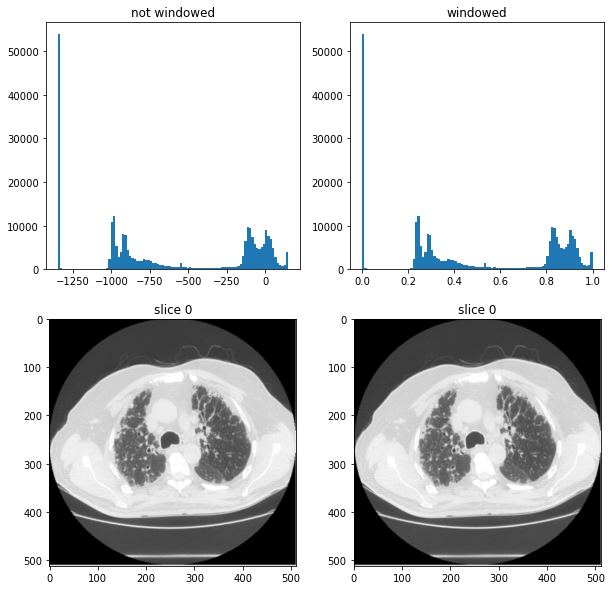

(1, 512, 512)



going to segment slice 0 

(1, 212153) (94249, 1)
[0.2980855439688159, 0.8649001692671714]
[0.256776394197196, 0.7920243978222958]
good_labels: [2, 3]


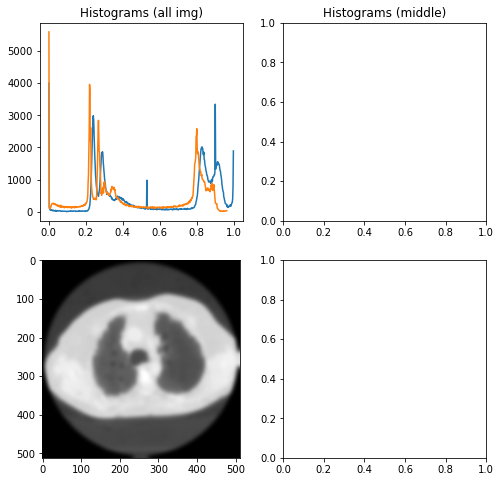

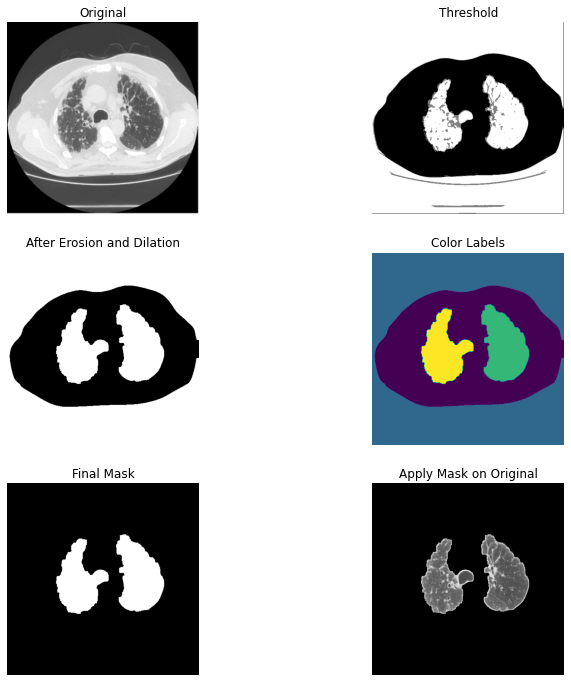




[  0  32  64  96 128 160 192 224 256 288 320 352 384 416 448 480] 
 [  0  32  64  96 128 160 192 224 256 288 320 352 384 416 448 480] 

 TBD VALIDITY CHECK




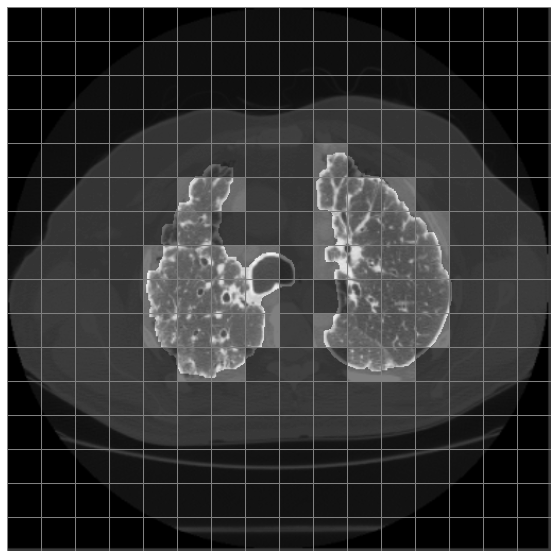

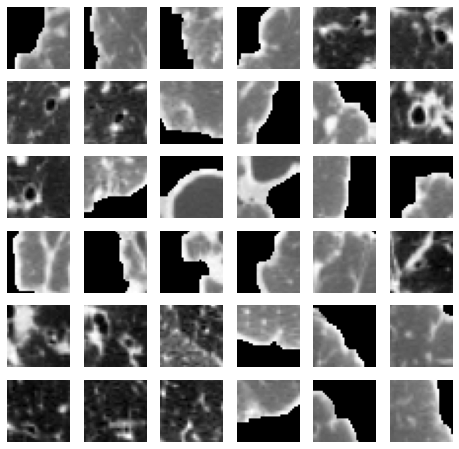

In [54]:
if __name__ == "__main__":
    
    ds_dir = Path('../data/prepared/osic-pulmonary-fibrosis-progression')
    random_select = True
    if random_select:
        # select scan randomly
        all_files = list(ds_dir.rglob('ID0*'))
        random_scan = random.choice(all_files)
        random_slice = np.random.randint(len(list(random_scan.rglob('*'))))
    else:
        # known slice
        random_scan, random_slice = case_scan, case_slice

    print('\n\n\ngoing to read and proces', random_scan, random_slice)
    scan = prepare_scan(str(random_scan), slice_size=512, window=[-600, 900], show_stages=True, slice_idx=random_slice)
    print(scan.shape)
    slice_idx = min(random_slice, scan.shape[0]-1)

    print('\n\n\ngoing to segment slice', slice_idx, '\n')
    mask = make_lungmask(scan[slice_idx], display=True)
    
    print('\n\n')
    patches, positions = get_patches(scan[slice_idx], mask, patch_size=32, min_occupancy=0.32, show_tiling=True)
    fig, ax = plt.subplots(6, 6, figsize=[8, 8])
    for i, patch in enumerate(patches):
        if i<36:
            ax[int(i/6), i % 6].imshow(patch, cmap='gray')
    for i in range(36):
        ax[int(i/6), i % 6].axis('off')
    plt.show()
    


### simple augmentation method

##### the tool is five a list of slices from the same scan
##### it is then do the following:
(1) segment an identify patches in all slices, to make a bank of "desired" patchs

(2) select randomly patches. selected pathes are not necessarily from the "desired" list, but the desired are more likely to be selected. 

(3) make 2 augmentation but tiling the patches in random order (different order for each augmentation)

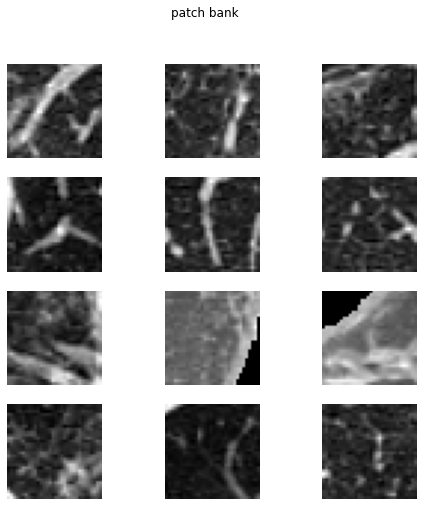

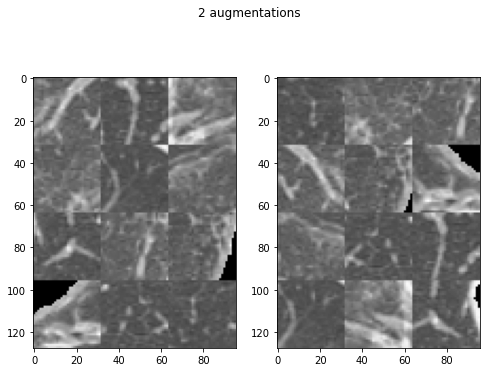

In [126]:
    # parameters
    slice_size = 512
    sub_patch_size = 32
    patch_size = 32
    target_size = (128, 96)
    assert patch_size % sub_patch_size == 0
    assert target_size[0] % patch_size == 0
    assert target_size[1] % patch_size == 0
    
    # randomly select scan and slices
    ds_dir = Path('../data/prepared/osic-pulmonary-fibrosis-progression')
    all_files = list(ds_dir.rglob('ID0*'))
    random_scan = random.choice(all_files)
    random_slices = np.random.choice(range(len(list(random_scan.rglob('*')))), 4)

    # make score map for patches
    patch_start_coor = np.arange(0, slice_size-sub_patch_size+1, sub_patch_size, dtype=int)
    patch_score = np.zeros((len(random_slices), len(patch_start_coor), len(patch_start_coor)))
    masked_slices = np.zeros((len(random_slices), slice_size, slice_size))
    for slice_idx, random_slice in enumerate(random_slices):
        scan = prepare_scan(str(random_scan), slice_size=slice_size, \
                            window=[-600, 900], show_stages=False, slice_idx=random_slice)
        mask = make_lungmask(scan[0], display=False)
        masked_slices[slice_idx] = scan * mask
        #patches, positions = get_patches(scan[slice_idx], mask, \
        #                                 patch_size=sub_patch_size, min_occupancy=0.32, show_tiling=True)
        for i0, c0 in enumerate(patch_start_coor):
            for i1, c1 in enumerate(patch_start_coor):
                patch_score[slice_idx, i0, i1] = mask[c0:c0+patch_size, c1:c1+patch_size].sum()
    # fix scores and introduce randomness
    patch_score = patch_score / (patch_size ** 2)
    patch_score = np.sqrt(patch_score) * 0.95 + 0.05
    patch_score *= np.random.uniform(low=0.5, high=1, size=patch_score.shape)
    # select patches
    patches, patch_positions = [], []
    for i in range(int(np.prod(target_size) / (patch_size ** 2))):
        next_idx = np.unravel_index(patch_score.argmax(), patch_score.shape)
        patch_score[next_idx] = 0
        i0, i1 = patch_start_coor[next_idx[1]], patch_start_coor[next_idx[2]]
        patches.append(masked_slices[next_idx[0], i0:i0+patch_size, i1:i1+patch_size])
        patch_positions.append([next_idx[0], i0, i1])
    #
    fig, ax = plt.subplots(int(target_size[0]/patch_size), int(target_size[1]/patch_size), figsize=[8, 8])
    i0, i1 = 0, 0
    for patch in patches:
        ax[i0, i1].imshow(patch, cmap='gray')
        ax[i0, i1].axis('off')
        i1 = (i1 + 1) % int(target_size[1]/patch_size)
        i0 += 1 if i1==0 else 0
    fig.suptitle('patch bank')
    plt.show()
    #
    # now do the augmentation
    #
    aug = []
    patch_shift_range = int(patch_size/8)
    for idx_aug in range(2):
        aug_img = np.zeros(target_size)
        order = np.random.permutation(len(patch_positions))
        #print(order)
        i_src = 0
        for tgt_i0 in range(0, target_size[0]-1, patch_size):
            for tgt_i1 in range(0, target_size[1]-1, patch_size):
                position = patch_positions[order[i_src]]
                idx_src_slice = position[0]
                (i0_src, i1_src) = position[1:3]
                # transhorm: random shift
                i0_src += np.random.randint(low=-patch_shift_range, high=patch_shift_range)
                i1_src += np.random.randint(low=-patch_shift_range, high=patch_shift_range)
                patch_src = masked_slices[idx_src_slice, i0_src:i0_src+patch_size, i1_src:i1_src + patch_size]
                # transform: rotations & flips
                flip = np.random.normal(loc=0, size=2) > 0
                if flip[0]:
                    patch_arc = np.flip(patch_src, axis=0)
                if flip[1]:
                    patch_src = np.flip(patch_src, axis=1)
                #
                aug_img[tgt_i0:tgt_i0+patch_size, tgt_i1:tgt_i1 + patch_size] = patch_src
                i_src += 1
        aug.append(aug_img)
    #
    print('\n\n')
    fig, ax = plt.subplots(1, 2, figsize=[8, 6])
    ax[0].imshow(aug[0], cmap='gray')
    ax[1].imshow(aug[1], cmap='gray')
    fig.suptitle('2 augmentations')
    plt.show()
    
   